In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as func

In [3]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

In [5]:
import matplotlib.pyplot as plt

# Data location

In [6]:
data_path = "data/clean_data.csv"

# Set seed

In [7]:
SEED = 42

# Load data

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.shape

(11627, 39)

In [10]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [11]:
df.iloc[:, 1: 23].columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC'],
      dtype='object')

In [12]:
df.iloc[:, 23: 31].columns

Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
       'HYPERTEN'],
      dtype='object')

In [13]:
print(df.iloc[:, 1: 23].shape[1], df.iloc[:, 23: 31].shape[1])

22 8


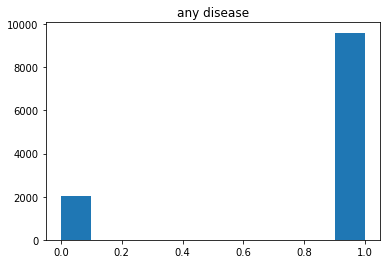

In [14]:
data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)
amax_label = np.amax(data[:, 23:31], axis=1)
hist,bins = np.histogram(amax_label) 

plt.hist(amax_label, bins = bins) 
plt.title("any disease") 
plt.show()

In [15]:
df

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448.0,1.0,195.0,39.0,106.0,70.0,0.0,0.0,26.970,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
1,2448.0,1.0,209.0,52.0,121.0,66.0,0.0,0.0,27.794,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
2,6238.0,0.0,250.0,46.0,121.0,81.0,0.0,0.0,28.730,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
3,6238.0,0.0,260.0,52.0,105.0,70.0,0.0,0.0,29.430,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
4,6238.0,0.0,237.0,58.0,108.0,66.0,0.0,0.0,28.500,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,9998212.0,1.0,173.0,46.0,126.0,82.0,0.0,0.0,19.170,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11623,9998212.0,1.0,153.0,52.0,143.0,89.0,0.0,0.0,25.740,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11624,9999312.0,0.0,196.0,39.0,133.0,86.0,1.0,30.0,20.910,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0
11625,9999312.0,0.0,240.0,46.0,138.0,79.0,1.0,20.0,26.390,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0


# DataSet

In [16]:
class HeatDeseaseDataset(Dataset): 
    
    def __init__(self, path, any_disease=False, label_indexes=[30, 31], split_indexes=[1, 23, 23, 31]):        
        self.data = np.loadtxt(path, delimiter=",", dtype=np.float32, skiprows=1)
        
        self.x = torch.from_numpy(self.data[:, split_indexes[0]:split_indexes[1]])
        if any_disease:
            self.y = torch.from_numpy(np.amax(self.data[:, split_indexes[2]:split_indexes[3]], axis=1))
        else:
            self.y = torch.from_numpy(pd.get_dummies(self.data[:, label_indexes[0]:label_indexes[1]].flatten()).to_numpy(dtype=np.float32))
        
        self.minMax = torch.from_numpy(compute_min_max(data_path, split_indexes[0], split_indexes[1]))
        
        self.len = len(self.data)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        inputs = torch.sub(self.x[idx], self.minMax[0])/ torch.sub(self.minMax[1],self.minMax[0])
        return inputs, self.y[idx]

# DataLoader

In [17]:
def create_dataloaders(dataset, batch_size):
    lengths = [round(len(dataset) * split) for split in [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]]
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=lengths, generator=torch.Generator().manual_seed(SEED))
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        prefetch_factor=1,
        persistent_workers=False,
        pin_memory=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )
    
    print(f'Total dataset: {len(train_dataloader) + len(val_dataloader) + len(test_dataloader)}, '
            f'train dataset: {len(train_dataloader)}, val dataset: {len(val_dataloader)}, test_dataset: {len(test_dataloader)}')
    return train_dataloader, val_dataloader, test_dataloader

# Accuracy

In [18]:
def accuracy_multi_prediction(pred, label):
    res = 0
    nb_prediction = pred.shape[1]

    for i in range(nb_prediction):
        if pred[0][i].item() == label[0][i].item():
            res += 1
    return res / nb_prediction

In [19]:
def accuracy(pred, label):
    if pred == label:
            return 1
    return 0

# Trainer

In [20]:
class Trainer:
    def __init__(self, model, class_weight, loss='dl', lr=0.5):
        possible_loss = {'dl' : DiceLoss(), 'nllloss' : nn.NLLLoss(weight=class_weights,reduction='mean'),
                         'cross' : nn.CrossEntropyLoss(weight=class_weights), 'mse' : nn.MSELoss(reduction='mean'),
                         'BCEloss' : nn.BCELoss(), 'BCElogits' : nn.BCEWithLogitsLoss(weight=class_weights)}
        
        self.model = model
        
        self.criterion = possible_loss[loss]
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.9, patience=2, cooldown=2)
        
        self.history = {'lr': [], 'loss': [], 'val_loss': []}
        self.max_val_acc = float('-inf')
        
    def fit(self, train_dataloader, val_dataloader, nb_epochs):
        for epoch in range(nb_epochs):
            print(f'Epoch {epoch + 1} / {nb_epochs}')
            train_loss = val_loss = train_acc = val_acc = 0.0
            
            self.model.train()
            pbar = tf.keras.utils.Progbar(target=len(train_dataloader))
            
            for i, batch in enumerate(train_dataloader):
                inputs, labels = batch

                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                
                # Forward pass to get output/logits
                output = self.model(inputs)

                # Calculate Loss: softmax --> cross entropy loss
                #print(output.shape, labels.shape)
                #print(output, labels)
                loss = self.criterion(output, labels)
                train_loss += loss
                #print(np.argmax(output.detach().numpy()[0]), np.argmax(labels.detach().numpy()[0]))
                train_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0

                # Getting gradients w.r.t. parameters
                loss.backward()

                pbar.update(i + 1, values=
                            [
                                ("loss", train_loss.item()/(i + 1)),
                                ("acc", train_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])
                
                # Updating parameters
                self.optimizer.step()
                
            
            print('Validation')
            
            self.model.eval()
            pbar = tf.keras.utils.Progbar(target=len(val_dataloader))
            
            with torch.no_grad():
                for i, batch in enumerate(val_dataloader):
                    inputs, labels = batch
                    output = self.model(inputs)
                    
                    val_loss += loss
                    val_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0
                    
                    pbar.update(i + 1, values=
                            [
                                ("loss", val_loss.item()/(i + 1)),
                                ("acc", val_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])
                    
            train_loss = train_loss / len(train_dataloader)
            train_acc = train_acc / len(train_dataloader)
            
            val_loss = val_loss / len(val_dataloader)
            val_acc = val_acc / len(val_dataloader)
            
            lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)
            
            if val_acc > self.max_val_acc:
                print(f'Model saved. Acc updated: {self.max_val_acc:.3f} -> {val_acc:.3f}')
                self.max_val_acc = val_acc
                torch.save(self.model.state_dict(), f'regression_logistice_{val_acc}.pt')
            
    def evaluate(self, test_dataloader, accuracy_function):
        correct = total_loss = total = 0.0
        #iterator = 0
        
        with torch.no_grad():       
            # Iterate through test dataset
            for i, (inputs, labels) in enumerate(test_dataloader):

                pred = self.model(inputs)

                loss = self.criterion(pred, labels)
                total_loss += loss
                    
                # Total correct predictions
                correct += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(pred.detach().numpy()[0]) else 0
                #iterator += 1

            total_accuracy = 100 * correct / len(test_dataloader)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}. total loss: {}.'.format(len(test_dataloader), loss.item(), total_accuracy, total_loss))
     

# Loss

In [21]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# The logistic regession function

In [22]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        #self.final_activation = func.sigmoid()

    def forward(self, x):
        out = self.linear(x)
        #out = func.sigmoid(out)
        return out

# Unbalanced classes

In [23]:
def compute_weight_class(labels):
    unique, counts = np.unique(np.argmax(labels.numpy(), axis=1), return_counts=True)
    class_weights=torch.tensor([(class_counts / labels.shape[0]) for class_counts in counts],dtype=torch.float32)
    return class_weights

# Min max compute

In [24]:
def compute_min_max(data_path, first_col_index=1, last_col_index=23):
    data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)[:, first_col_index:last_col_index]
    return np.stack((data.min(axis=0), data.max(axis=0)))

# Prepare the data

In [25]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

In [26]:
batch_size = 1

dataset = HeatDeseaseDataset(data_path, any_disease=False)
class_weights = compute_weight_class(dataset.y)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(dataset, batch_size)

Total dataset: 11627, train dataset: 6860, val dataset: 2442, test_dataset: 2325


# Data verification

In [27]:
participant = next(iter(train_dataloader))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[0.0000, 0.2750, 0.7347, 0.2796, 0.4167, 0.0000, 0.0000, 0.1076, 1.0000,
         0.0000, 0.2077, 0.0729, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.9157, 1.0000, 0.4190, 0.3009]])
label ==>
 tensor([[0., 1.]])


# Train

In [28]:
model = LogisticRegression(22,2)

In [29]:
trainer = Trainer(model, class_weights, loss='BCElogits', lr=0.05)

In [30]:
trainer.fit(
    train_dataloader,
    val_dataloader,
    nb_epochs=20
) 

Epoch 1 / 20
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2292 - acc: 0.7358 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 916us/step - loss: 0.0077 - acc: 0.7971 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.792
Epoch 2 / 20
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1812 - acc: 0.7930 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 979us/step - loss: 0.2876 - acc: 0.8031 - lr: 0.0500
Model saved. Acc updated: 0.792 -> 0.797
Epoch 3 / 20
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1722 - acc: 0.8113 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.4488 - acc: 0.7881 - lr: 0.0500
Epoch 4 / 20
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1691 - acc: 0.8024 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 974us/step - loss: 0.3827 - acc: 0.7962 - lr: 0.0500
Epoch 5 / 20
6860/6860 [=

In [31]:
df.iloc[:, 1: 23].columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC'],
      dtype='object')

In [32]:
model.linear.weight

Parameter containing:
tensor([[ 0.2780, -0.0199, -0.4907, -3.7578, -2.4775,  0.2200, -0.3948, -1.2568,
         -0.3156, -0.6820, -0.1852,  0.1146,  0.5058, -0.1077,  0.4792, -0.1905,
          0.0087, -5.3572,  0.6992,  0.4524,  0.1914,  0.2551],
        [-0.3560,  0.0892,  0.4494,  7.4106,  4.0419, -0.1798,  0.7122,  1.9148,
          0.3935,  0.8456, -0.0636,  0.0836, -0.4666,  0.3109, -0.7901,  0.2438,
          0.0742,  6.1984, -0.5443, -0.6070, -0.2071, -0.5447]],
       requires_grad=True)

# Test

In [33]:
trainer.evaluate(test_dataloader, accuracy)

Iteration: 2325. Loss: 0.0007564895786345005. Accuracy: 83.95698924731182. total loss: 364.517333984375.


**Test on one participant**

In [34]:
print(len(test_dataloader))

2325


In [35]:
# Confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def prediction_analyse(dataloader):
    all_predictions = np.array([])
    all_labels = np.array([])
    for i, (inputs, labels) in enumerate(dataloader):
        pred = model(inputs)
        print("pred", pred)
        pred = np.where( pred[0].detach().numpy() < 0., 0, 1)
        print("np where", pred)
        print("labels", labels)
        pred = np.argmax(pred)
        label = np.argmax(labels[0].detach().numpy())
        print("argmax pred", pred)
        print("argmax label", label, "\n\n\n")
        all_predictions = np.append(all_predictions, pred)
        all_labels = np.append(all_labels, label)

    cm = confusion_matrix(all_labels, all_predictions)
    #
    #print(cm)

    display = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=clf.classes_)
    display.plot()
    plt.show()

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatif

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    #positive predictive value
    PPV = TP / (TP + FP)
    #negative predictive value
    NPV = TN / (TN + FN)


    print(f'sensitivity : {sensitivity}, specificity : {specificity}, PPV : {PPV}, NPV : {NPV}')

pred tensor([[-6.6643,  8.4413]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.1500,  9.5380]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3401, -0.0306]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.4964,  9.4440]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.7355, -0.8226]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-0.5068,  0.6876]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.5943,  8.4148]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.5270, -0.6734]], grad_fn=<AddmmBackward0>)
np

np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.0777, -0.0184]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-0.1431,  0.5011]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2633,  8.5483]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.6406, -1.1746]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.1529,  0.1692]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.6572, -1.1609]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[ 0.3695, -0.0205]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax 

pred tensor([[ 0.2067, -0.1567]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-5.1422,  6.0361]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.4513,  0.7936]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.8966,  7.0965]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.2399, -0.1571]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.1756,  9.5925]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-4.9736,  6.1994]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2096,  7.8507]], grad_fn=<AddmmBackward0>)
np

argmax pred 1
argmax label 0 



pred tensor([[ 0.2097, -0.2874]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.7949,  8.1829]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.1362,  1.7867]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.1534, -0.4667]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[ 0.4008, -0.8597]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.5986,  8.0920]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.3522, -0.8359]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.4198,  9.984

pred tensor([[-4.7440,  5.9025]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0825, -0.0259]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-7.1524,  8.5765]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.6556,  6.9352]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2071, -0.2024]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.9493, 10.3450]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.1662, -0.1115]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-6.1455,  7.3821]], grad_fn=<AddmmBackward0>)
np

np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3549,  0.5373]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.7049,  1.4769]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3874,  1.1569]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-7.6346,  9.9327]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.8903, 10.5604]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.0343,  8.9713]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 1.0536, -1.4961]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax 

pred tensor([[-4.4942,  5.3748]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 1.4038, -1.7363]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.5763,  6.7560]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.5500,  7.8506]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0986, -0.0482]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-7.0943,  8.6473]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 1.2655, -1.9715]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.6282,  6.7173]], grad_fn=<AddmmBackward0>)
np

pred tensor([[ 0.1836, -0.0397]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-6.4761,  7.9802]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.2041,  1.6859]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2485,  8.0109]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.4015, -0.4909]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.6707,  6.8320]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.3247,  7.4691]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.3878, -0.7919]], grad_fn=<AddmmBackward0>)
np

labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.1089,  0.0939]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.2450,  0.1125]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[ 1.2495, -1.7881]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[0.1279, 0.1104]], grad_fn=<AddmmBackward0>)
np where [1 1]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-5.7624,  6.8352]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.9817,  9.0413]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.0671,  1.6089]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred 

pred tensor([[-5.0191,  5.6072]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.6106,  8.0175]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[0.0889, 0.4237]], grad_fn=<AddmmBackward0>)
np where [1 1]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-6.6513,  8.4015]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.1421,  7.2843]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.5590,  9.5706]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.0996,  5.9090]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2976,  8.3349]], grad_fn=<AddmmBackward0>)
np w

pred tensor([[-5.0908,  5.9536]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.4876,  0.5997]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.0301,  1.2731]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.1774, -0.5508]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.7574,  7.5081]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.1135,  1.3861]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.5304, -0.4910]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-0.6937,  1.2238]], grad_fn=<AddmmBackward0>)
np

np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-5.9157,  7.5804]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2386, -0.6861]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.8917,  7.3472]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.8095,  9.8539]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0241, -0.0632]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[ 0.0959, -0.3344]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.8276,  8.9392]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax 

pred tensor([[-7.6670,  9.9022]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.9147,  7.1685]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8903,  8.8394]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.9695, -1.2220]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.2684,  1.5203]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.8151,  7.0462]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.7486,  9.7157]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0678, -0.2090]], grad_fn=<AddmmBackward0>)
np

pred tensor([[-7.6511, 10.0063]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8133,  9.4515]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.6496,  8.3685]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.6602,  0.9136]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.1583,  0.7059]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.0520,  1.6570]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.7694,  8.6851]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.2779,  9.1919]], grad_fn=<AddmmBackward0>)
np

argmax pred 1
argmax label 1 



pred tensor([[ 0.3299, -0.5040]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.2844,  0.4921]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-0.1904,  0.1855]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[0.2037, 0.1543]], grad_fn=<AddmmBackward0>)
np where [1 1]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-7.2694,  9.0426]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.4765,  0.5621]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2411, -0.3608]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.4289,  9.6051]

pred tensor([[ 0.6127, -1.2911]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[ 0.0788, -0.1337]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-6.1411,  7.8071]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.9420,  1.2102]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2667,  8.0638]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2307, -0.4495]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.7074,  8.2766]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.0531, -0.3166]], grad_fn=<AddmmBackward0>)
np

pred tensor([[ 0.5139, -0.6577]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.0808,  0.1069]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-6.6052,  8.0564]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2423, -0.4169]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[0.1048, 0.2653]], grad_fn=<AddmmBackward0>)
np where [1 1]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[ 0.4993, -0.5026]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.2049,  8.9773]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.7499,  6.9964]], grad_fn=<AddmmBackward0>)
np w

pred tensor([[-7.3655,  8.7212]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8914,  8.8823]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.9446,  1.0843]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0669, -0.1260]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.5758,  0.8489]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 1.1331, -1.2361]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-5.2422,  6.7827]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2294, -0.0116]], grad_fn=<AddmmBackward0>)
np

pred tensor([[ 0.5404, -0.5830]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-7.8105, 10.4897]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.7642, -1.0954]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-0.4136,  0.6304]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.4870, -0.5944]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.4490,  2.0622]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.7676, -1.1308]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-5.0166,  6.2473]], grad_fn=<AddmmBackward0>)
np

pred tensor([[-5.8088,  6.8909]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0688,  7.0041]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2571, -0.1639]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.0181, -0.2894]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.1091,  7.5330]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.4018, -0.3111]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.3619,  7.8361]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0975,  7.5660]], grad_fn=<AddmmBackward0>)
np

labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.6792,  0.4557]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-5.3217,  6.2039]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.5407,  0.7301]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.5258,  7.7676]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0116,  0.1353]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.0989,  0.1362]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-6.1597,  7.7360]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pre

argmax pred 1
argmax label 1 



pred tensor([[-6.6212,  8.4011]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.0013, -0.2452]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.2122,  1.5321]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.4442,  9.6897]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.1831, -0.0004]], grad_fn=<AddmmBackward0>)
np where [0 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-5.6527,  6.9131]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[0.0493, 0.0625]], grad_fn=<AddmmBackward0>)
np where [1 1]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-7.7016,  9.2334]

pred tensor([[-5.1948,  6.3652]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.2146,  0.2111]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-0.2411,  0.6661]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2946, -0.2919]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[ 0.0234, -0.1985]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.5806,  0.2660]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.7402,  8.9764]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8874,  9.2166]], grad_fn=<AddmmBackward0>)
np

pred tensor([[ 0.2059, -0.8220]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-0.1909,  0.6289]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.0005, -0.0435]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.4742,  7.9579]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.2639,  6.1767]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0859,  7.8289]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.3885,  7.8687]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-8.1150, 10.7550]], grad_fn=<AddmmBackward0>)
np

labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.0407,  1.5070]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.1435,  9.2588]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8939,  8.2001]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.7663, -0.4630]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.2369,  1.5869]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.6578,  0.9178]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.3181,  1.7522]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pre

pred tensor([[-1.0194,  1.5438]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.5323,  6.5060]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0696,  7.8253]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.6221,  6.3877]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2136, -0.0488]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[ 1.2180, -1.5012]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[ 0.6311, -0.7705]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-6.5706,  8.1873]], grad_fn=<AddmmBackward0>)
np

labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[ 1.3353, -1.6132]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[ 0.4035, -0.1923]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-6.7147,  8.7066]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.1840,  0.6502]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-5.4621,  6.5260]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.8056,  6.9100]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.2251,  9.5668]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pre

pred tensor([[ 0.8584, -0.9752]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-0.8036,  1.2303]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3161,  0.4771]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.7841,  1.1242]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.3688,  6.8717]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.2644,  7.8505]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.6530,  9.4868]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.2838, -0.3050]], grad_fn=<AddmmBackward0>)
np

pred tensor([[-0.3894,  0.1290]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-6.0342,  7.5221]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.7464,  9.8763]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.5841, -0.6128]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[0., 1.]])
argmax pred 0
argmax label 1 



pred tensor([[-5.1205,  5.5629]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[ 0.3398, -0.1833]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.3323,  1.8261]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3548,  0.3457]], grad_fn=<AddmmBackward0>)
np

labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-4.7895,  5.9055]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0259,  7.6263]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.5149,  0.6821]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.0172,  7.3998]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.2304,  9.3285]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.3615,  0.5687]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-1.2122,  1.4160]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pre

pred tensor([[ 0.5404, -0.6357]], grad_fn=<AddmmBackward0>)
np where [1 0]
labels tensor([[1., 0.]])
argmax pred 0
argmax label 0 



pred tensor([[-1.0570,  1.4961]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-0.4147,  0.3609]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[1., 0.]])
argmax pred 1
argmax label 0 



pred tensor([[-0.8267,  1.1439]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-5.8112,  6.8795]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.1655,  9.2966]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-6.8934,  8.2641]], grad_fn=<AddmmBackward0>)
np where [0 1]
labels tensor([[0., 1.]])
argmax pred 1
argmax label 1 



pred tensor([[-7.8675, 10.0483]], grad_fn=<AddmmBackward0>)
np

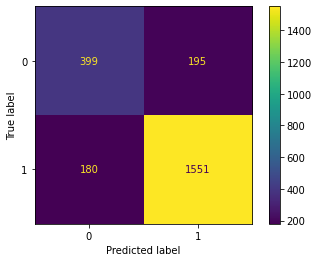

sensitivity : 0.8960138648180243, specificity : 0.6717171717171717, PPV : 0.8883161512027491, NPV : 0.689119170984456


In [36]:
prediction_analyse(test_dataloader)